In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
%%capture output
try:
    import bayes_nanospace2025

    print("Already installed")
except ImportError:
    %pip install "bayes_nanospace2025 @ git+https://github.com/Mads-PeterVC/nanospace2025.git" # Install from GitHub. 
    print("Installed bayes_nanospace2025 from GitHub")

: 

In [ ]:
import numpy as np
from bayes_nanospace2025 import GaussianProcess, RadialBasis, Noise, Constant, plot_gp_prediction, YourCodeHere
from bayes_nanospace2025.tutorial.gp import PredictionResult
from bayes_nanospace2025.tutorial.test_functions import himmelblau
from bayes_nanospace2025.tutorial.bo_widget import plot_bayes_opt_plotly
import matplotlib.pyplot as plt
from typing import Callable

: 

## Bayesian Optimization with GPs.

With Bayesian optimization (BO) we wish to optimize some, possibly blackbox, function that is 
typically quite expensive to evaluate such as expensive calculations, such as DFT, or experiments. 

Formally, we say that we are looking for 

$$
x_{\mathrm{opt}} = \mathrm{argmin}_{x \in D} f(x)
$$

Wikipedia describes Bayesian optimization like so; 
> "Since the objective function is unknown, the Bayesian strategy is to treat it as a random function and **place a prior over it**. The prior captures beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the **posterior distribution** over the objective function. The posterior distribution, in turn, is used to construct an **acquisition function** that determines the next query point".

We've already seen how GPs describe a distribution over functions with the prior defined by the covariance function (i.e. kernel) and we've seen how to condition the distribution to 
obtain a posterior distribution where the functions match our observations. The part we haven't seen so far is the use of an **acquisiton function**. A rough outline of the BO algorithm we will develop is as follows;

---

Initialize

- Create a GP model over the domain of interest $D$. 

And then iteratively do these steps

1. Evaluate an acquistion function at points in the domain, the acquisition function is based on the GP. 
2. Choose the next observation according to the acquisition function ($\mathrm{argmin}$ or $\mathrm{argmax}$ depending on definition).
3. Evaluate the objective function at "acquired"-coordinate $x_{\mathrm{acq}}$ to get $y_{\mathrm{acq}}$.
4. Add the new observation to our set of observations $(X, y)$
5. Update the GP with new observations.

---

An example of an acquisiton function is the lower confidence bound

$$
\mathrm{LCB}(x) = \mu(x) - \kappa \sigma(x)
$$

Where $\mu(x)$ is the predicted value and $\sigma(x)$ is the predicted standard deviation 'uncertainty' and $\kappa$ is a weighting factor between the two terms. 
This acquisition function will thus have minimas either at locations where the mean is low or where there's a large uncertainty. 

### Bayesian Optimization for a 1D function.

Well start by implementing BO for a 1D function so we can visualize how it progresses. 

#### Bayesian Optimization with Lower-Confidence Bound acquisition function.

In [ ]:
# Define the GP
gp = GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=1) + Noise(0.001))

objective_function = himmelblau  # Define the objective function

# Lists for observations
X_obs = []
y_obs = []

# Lists for storing things for visualization
predictions = []
acquisition_functions = []

# Settings:
n_iterations = 10
kappa = 2
X_query = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)  # Query points for predictions

for iteration in range(n_iterations):
    # Make predictions with the GP
    prediction = gp.predict(X_query)  # Your code here
    predictions.append(prediction)

    # Construct the LCB acquisition function
    # Remember that the 'prediction' object contains 'prediction.mean' and 'prediction.variance' -> std = sqrt(variance)
    lcb = prediction.mean - kappa * np.sqrt(prediction.variance)  # Your code here
    acquisition_functions.append(lcb)

    # Find the next point to sample (the minimum of the LCB)
    # Use np.argmin to find the index of the minimum value in lcb

    if len(X_obs) > 0:
        next_x = X_query[np.argmin(lcb)]  # Your code here
    else:
        next_x = np.random.choice(X_query.flatten(), 1)  # If no observations, sample randomly from the query points

    # Evaluate the function at the next point
    next_y = objective_function(next_x.reshape(1, -1))  # Your code here

    # Add new observation to the lists
    X_obs.append(next_x)
    y_obs.append(next_y)

    # Update the GP with the new observations
    gp.set_prior_mean(np.mean(y_obs))

    X_obs_arr = np.array(X_obs).reshape(-1, 1)
    y_obs_arr = np.array(y_obs).reshape(-1, 1)
    gp.condition(X_obs_arr, y_obs_arr)  # Update the GP with the new observations


: 

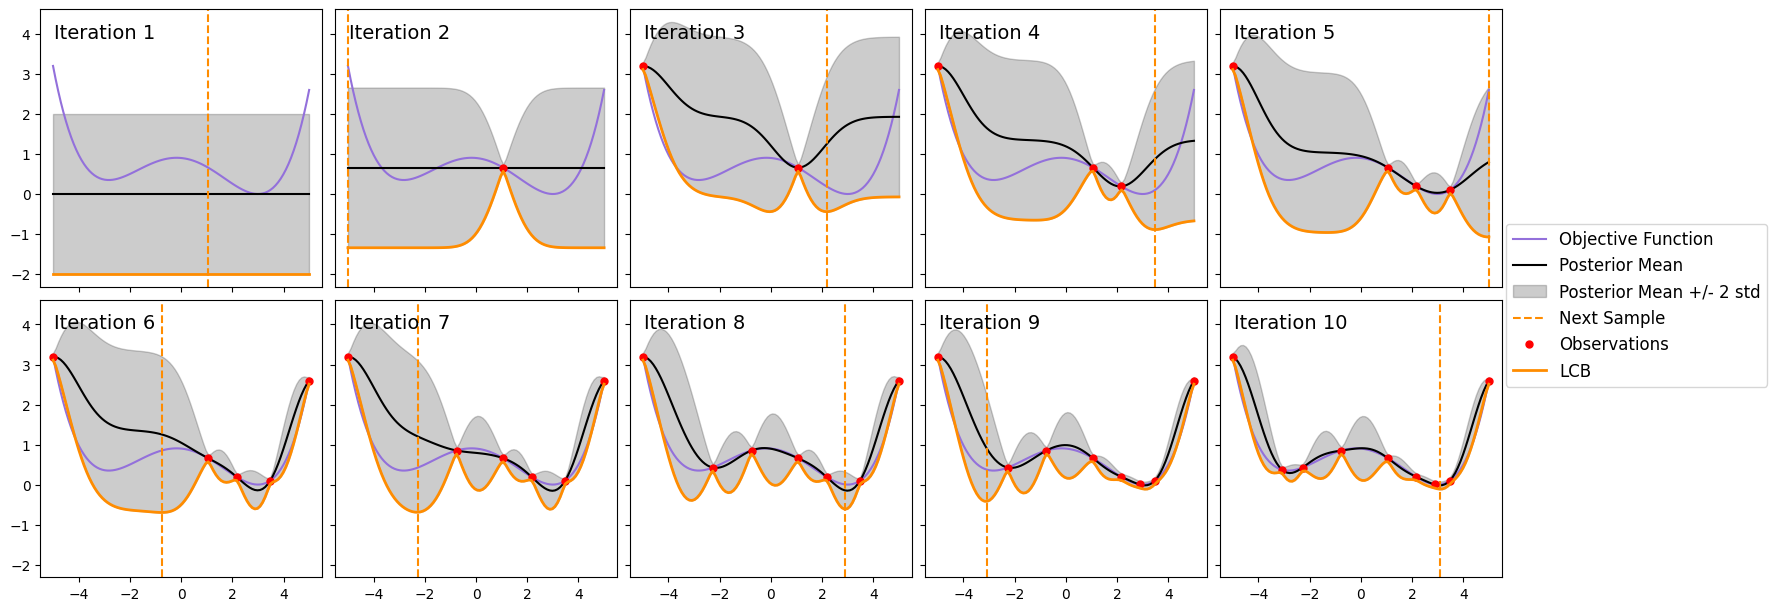

: 

In [ ]:
sz = 3
fig, ax = plt.subplots(2, 5, figsize=(5 * sz, 2 * sz), sharex=True, sharey=True, layout="constrained")
axes = ax.flatten()

for i in range(n_iterations):
    ax = axes[i]

    ax.plot(X_query, objective_function(X_query), label="Objective Function", color="mediumpurple")

    plot_gp_prediction(ax, predictions[i], color="black")
    ax.axvline(X_obs[i], color="darkorange", linestyle="--", label="Next Sample")
    ax.plot(X_obs[0:i], y_obs[0:i], "ro", markersize=5, label="Observations")
    ax.plot(X_query, acquisition_functions[i], "-", label="LCB", color="darkorange", linewidth=2)

    ax.text(
        0.05,
        0.95,
        f"Iteration {i + 1}",
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment="top",
    )

# Put one legend outside on the right
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.18, 0.5), fontsize="large");

#### Bayesian Optimization with Thompson sampling.

An interesting acquistion function that uses the properties of the Gaussian Process 
is Thompson sampling.

In Thompson sampling we draw a sample function from the GP and choose the optimal location according to 
that sample. So the GP posterior defines a distribution over functions conditioned on the data and 
we choose random one and select the optimum of that function. 

In [ ]:
# Define the GP
gp = GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=1) + Noise(0.001))

objective_function = himmelblau  # Define the objective function

# Lists for observations
X_obs = []
y_obs = []

# Lists for storing things for visualization
predictions = []
acquisition_functions = []

# Settings:
n_iterations = 10
kappa = 2
X_query = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)  # Query points for predictions

for iteration in range(n_iterations):
    # Make predictions with the GP
    prediction = gp.predict(X_query)  # Your code here
    predictions.append(prediction)

    # Construct the Thompson sampling acquisition function
    sample = gp.sample(X_query, n_samples=1).T
    acquisition_functions.append(sample)

    # Find the next point to sample - the minimum of the sampled function
    next_x = X_query[np.argmin(sample)]  # Your code here

    # Evaluate the function at the next point
    next_y = objective_function(next_x.reshape(1, -1))  # Your code here

    # Add new observation to the lists
    X_obs.append(next_x)
    y_obs.append(next_y)

    # Update the GP with the new observations
    gp.set_prior_mean(np.mean(y_obs))

    X_obs_arr = np.array(X_obs).reshape(-1, 1)
    y_obs_arr = np.array(y_obs).reshape(-1, 1)
    gp.condition(X_obs_arr, y_obs_arr)  # Update the GP with the new observations


: 

Again we can plot each iteration of the BO.

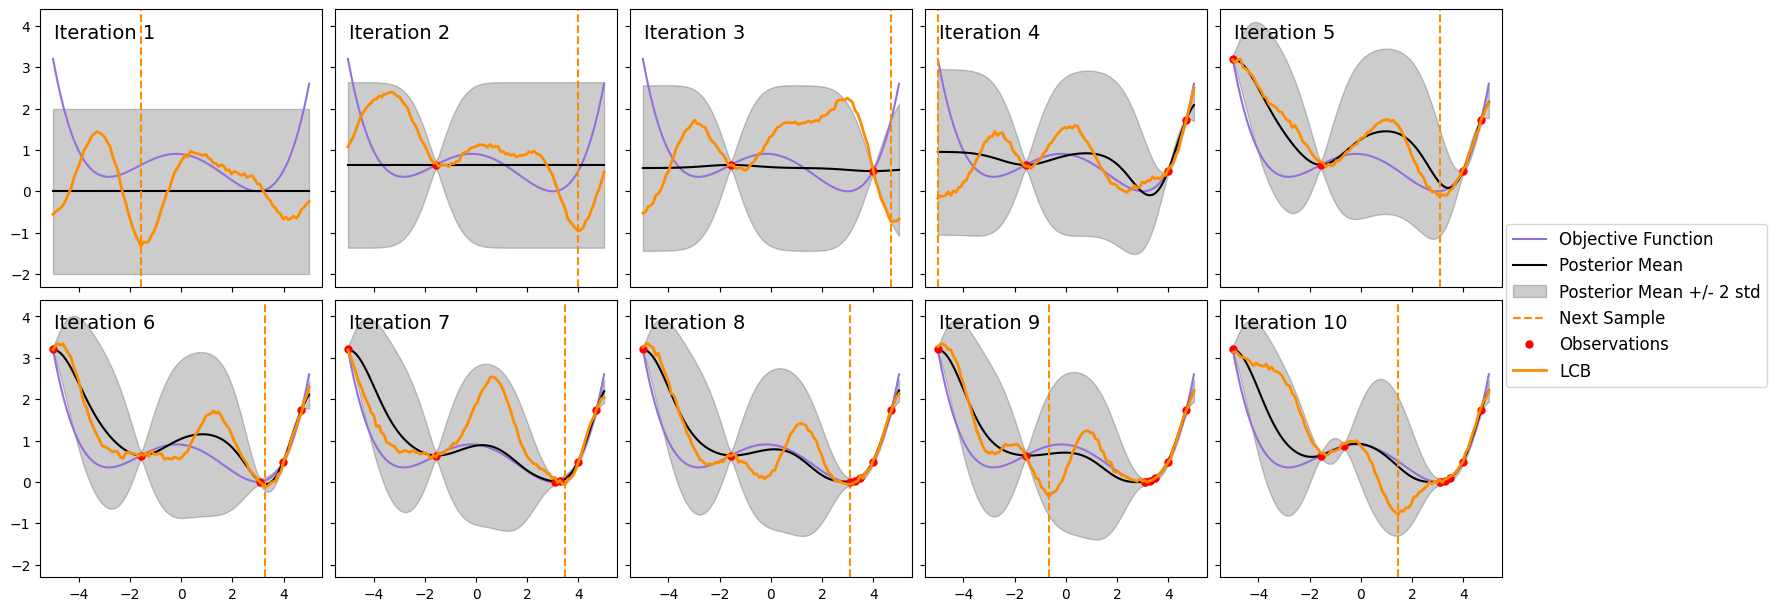

: 

In [ ]:
sz = 3
fig, ax = plt.subplots(2, 5, figsize=(5 * sz, 2 * sz), sharex=True, sharey=True, layout="constrained")
axes = ax.flatten()

for i in range(n_iterations):
    ax = axes[i]

    ax.plot(X_query, objective_function(X_query), label="Objective Function", color="mediumpurple")

    plot_gp_prediction(ax, predictions[i], color="black")
    ax.axvline(X_obs[i], color="darkorange", linestyle="--", label="Next Sample")
    ax.plot(X_obs[0:i], y_obs[0:i], "ro", markersize=5, label="Observations")
    ax.plot(X_query, acquisition_functions[i], "-", label="LCB", color="darkorange", linewidth=2)

    ax.text(
        0.05,
        0.95,
        f"Iteration {i + 1}",
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment="top",
    )

# Put one legend outside on the right
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.18, 0.5), fontsize="large");

### Bayesian Optimizer class

Now we've seen the concept of Bayesian Optimization with GPs in action we can wrap it up 
in a little class to avoid having to repeat code over and over. 

To get some flexibility we will first define an `AcquisitionFunction`-class that, unsurprisingly
defines the acquisition function.

In [ ]:
class AcquisitionFunction:
    def __init__(self):
        pass

    def compute(self, prediction: PredictionResult, GaussianProcess, X_query: np.ndarray) -> tuple[int, np.ndarray]:
        """
        Returns the index of the next point to sample and the acquisition function values over the query points.
        """
        raise NotImplementedError("This method should be implemented by subclasses")

: 

In [ ]:
class LowerConfidenceBound(AcquisitionFunction):
    def __init__(self, kappa: float = 2.0):
        super().__init__()
        self.kappa = kappa

    def compute(self, prediction: PredictionResult, GaussianProcess, X_query: np.ndarray) -> tuple[int, np.ndarray]:
        """
        Compute the Lower Confidence Bound (LCB) acquisition function.
        """
        lcb = prediction.mean - self.kappa * np.sqrt(prediction.variance)  # YCH: Construct the LCB acquisition function
        next_index = np.argmin(lcb)  # YCH: Find the index of the minimum value in lcb
        return next_index, lcb

: 

In [ ]:
class ThompsonSampling(AcquisitionFunction):
    def __init__(self):
        super().__init__()

    def compute(self, prediction: PredictionResult, GaussianProcess, X_query: np.ndarray) -> tuple[int, np.ndarray]:
        """
        Compute the Thompson sampling acquisition function.
        """
        sample = GaussianProcess.sample(X_query, n_samples=1).T  # YCH: Sample from the GP
        next_index = np.argmin(sample)  # YCH: Find the index of the minimum value in the sampled function
        return next_index, sample.flatten()

: 

Like with our GP I find it useful to have a data class to carry our results, I've 
created a minimal one below

In [ ]:
from dataclasses import dataclass, field


@dataclass
class OptimizationResult:
    X_obs: list = field(default_factory=list)  # List of observed input points
    y_obs: list = field(default_factory=list)  # List of observed output values
    predictions: list[np.ndarray] = field(default_factory=list)  # List of predictions made by the GP
    acquisition_values: list[np.ndarray] = field(default_factory=list)  # List of acquisition function values
    acquisition_indices: list[int] = field(default_factory=list)

    def update(
        self, X_new: np.ndarray, y_new: np.ndarray, prediction: np.ndarray, acq_values: np.ndarray, acq_index: int
    ):
        """
        Update the optimization result with new observations.
        """
        self.X_obs.append(X_new)
        self.y_obs.append(y_new)
        self.predictions.append(prediction)
        self.acquisition_values.append(acq_values)
        self.acquisition_indices.append(acq_index)


: 

Now we can wrap things up - like always there are many ways of going about it. 

I've laid out one option below with the following methods;

- `iterate`: Run an iteration of the BO, making GP predictions and evaluating the acquisition function.
- `query_objective`: Query the objective function.
- `update_gp`: Update the GP with new data.
- `optimize`: Main method.



In [ ]:
class BayesianOptimizer:
    def __init__(
        self,
        objective_function: Callable,
        gp: GaussianProcess,
        acquisition_function: AcquisitionFunction,
        objective_input_index: bool = False,
    ):
        self.objective_function = objective_function
        self.gp = gp
        self.acquisition_function = acquisition_function
        self.objective_input_index = objective_input_index

    def iterate(self, X_query):
        # Make predictions with the GP
        prediction = self.gp.predict(X_query)  # YCH: Make predictions with the GP

        # Compute the acquisition function
        acq_index, acq_values = self.acquisition_function.compute(
            prediction, self.gp, X_query
        )  # YCH: Compute the acquisition function

        # Find the next point to sample
        next_x, next_y = self.query_objective(X_query, acq_index)  # YCH: Query the objective function at the next point

        return next_x, next_y, prediction, acq_values, acq_index

    def query_objective(self, X_query, acq_index):
        next_x = X_query[acq_index]
        if not self.objective_input_index:
            next_y = self.objective_function(next_x.reshape(1, -1))
        else:
            next_y = self.objective_function(acq_index)
        return next_x, next_y

    def update_gp(self, results: OptimizationResult):
        """
        Update the Gaussian Process with new observations.
        """
        y_obs_arr = np.array(results.y_obs).reshape(-1, 1)  # Ensure y_obs is a 2D array
        X_obs_arr = np.atleast_2d(np.array(results.X_obs))

        self.gp.set_prior_mean(np.mean(y_obs_arr))
        self.gp.condition(X_obs_arr, y_obs_arr)

    def optimize(self, X_query: np.ndarray, n_iterations: int):
        results = OptimizationResult()

        for _ in range(n_iterations):
            next_x, next_y, prediction, acq_values, acq_index = self.iterate(X_query)  # YCH: Run an iteration of the BO
            results.update(
                next_x, next_y, prediction, acq_values, acq_index
            )  # YCH: Update the results with new observations - using results.update
            self.update_gp(results)  # YCH: Update the GP with new data

        return results

: 

Now we can try our class on the Himmelblau function and confirm that it works

In [ ]:
optimizer = BayesianOptimizer(
    objective_function=himmelblau,
    gp=GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=1) + Noise(0.001)),
    acquisition_function=LowerConfidenceBound(kappa=2.0),
)

X_query = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)  # Query points for predictions
result = optimizer.optimize(X_query, n_iterations=10)

: 

In [ ]:
truth = himmelblau(X_query).flatten()
plot_bayes_opt_plotly(result, X_plot=X_query.flatten(), truth=truth)

: 

We can also try it for a 2D problem

Play around with the settings below and compare with Wikipedia's article on [Himmelblau's function](https://en.wikipedia.org/wiki/Himmelblau%27s_function).

In [ ]:
x = np.linspace(-5, 5, 25)
X1, X2 = np.meshgrid(x, x)
X_query = np.vstack([X1.ravel(), X2.ravel()]).T

acquisition_function = LowerConfidenceBound(kappa=2.0)  # YCH: Define the acquisition function. Try both!
gp = GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=1) + Noise(0.001))

optimizer = BayesianOptimizer(objective_function=himmelblau, gp=gp, acquisition_function=acquisition_function)
result = optimizer.optimize(X_query, n_iterations=15)

: 

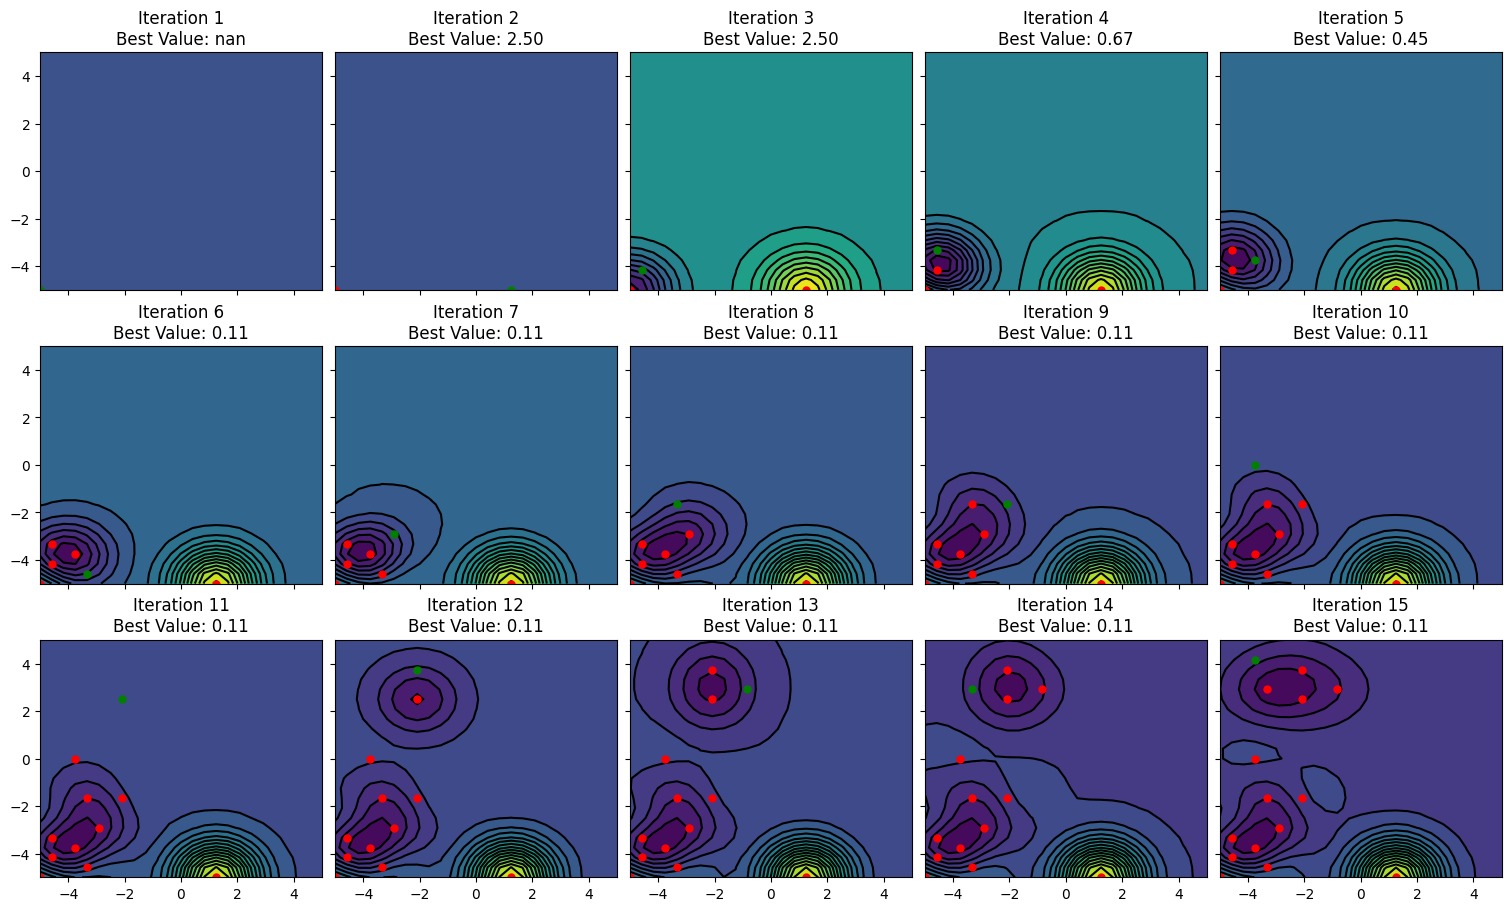

: 

In [ ]:
ncols = 5
nrows = 3
sz = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * sz, nrows * sz), sharex=True, sharey=True, layout="constrained")
axes = axes.flatten()

for i, ax in enumerate(axes):
    Z = result.predictions[i].mean.reshape(X1.shape)
    ax.contour(X1, X2, Z, colors="black", levels=20)
    ax.contourf(X1, X2, Z.reshape(X1.shape), levels=20)

    for j in range(i):
        ax.plot(result.X_obs[j][0], result.X_obs[j][1], "ro", markersize=5, label="Observations")

    ax.plot(result.X_obs[i][0], result.X_obs[i][1], "go", markersize=5, label="Next Sample")

    if i > 0:
        best_value = np.min(result.y_obs[0:i])
    else:
        best_value = np.nan
    ax.set_title(f"Iteration {i + 1}\nBest Value: {best_value:.2f}")


## Bayesian Optimization for Atomistic Systems

To illustrate Bayesian optimization for atomistic systems we will investigate 
the energy landscape of a small metal cluster. The cell below use the `ngl`-widget 
of ASE to display the cluster, you can use the slider to see the configurations.

In [ ]:
from bayes_nanospace2025.tutorial.atoms_dataset import get_atoms_data
from ase.visualize import view

atoms_data = get_atoms_data()

view(atoms_data, viewer="ngl")

/Users/au616397/Repositories/bayes_nanospace2025/.venv/lib/python3.12/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


: 

The objective function is the potential energy, we will use an effective-medium-theory (EMT) calculator, 
but this could be replaced with a more sophisticated potential, such as DFT.

In [ ]:
from ase.calculators.emt import EMT

def objective_function(index):
    if isinstance(index, np.ndarray):
        index = index.flatten()[0]

    atoms = atoms_data[index]
    atoms.calc = EMT()  # Set the calculator
    energy = atoms.get_potential_energy()  # Calculate the potential energy
    return energy  # Return the energy as the objective function value

: 

In [ ]:
objective_function(np.array([[0]]))  # Example usage of the objective function

9.735118363665656

: 

In [ ]:
X_query = np.arange(len(atoms_data)).reshape(-1, 1)  # Query points for predictions
acquisition_function = LowerConfidenceBound(kappa=2.0)  # Define the acquisition function
gp = GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=10) + Noise(0.0001), prior_mean=10)

optimizer = BayesianOptimizer(objective_function=objective_function, gp=gp, acquisition_function=acquisition_function)

result = optimizer.optimize(X_query, n_iterations=25)

: 

In [ ]:
truth = np.array([objective_function(i) for i in range(len(atoms_data))])  # Calculate the true values for the atoms
X_plot = np.arange(len(atoms_data))  # X values for plotting

plot_bayes_opt_plotly(result, X_plot=X_plot, truth=truth)  # Call the function to plot the Bayesian optimization results

: 

This is rather unimpressive! A large part of the reason is that the coordinates, our features, we use are not 
particularly useful for atomic systems, recall that we want something that has these invariances: 

- **Permutational**: Swapping of atoms of the same species should not change the feature.
- **Translational**: A rigid translation should not change the feature. 
- **Rotational**: A rotation should not change the feature. 

The features we use are just the index of the atoms in the list, and they have none of these properties. 

In [ ]:
def calculate_coulomb_matrix(atoms):
    d = atoms.get_all_distances() + np.eye(len(atoms)) * 10  # n_atoms x n_atoms matrix.
    species = atoms.get_atomic_numbers().reshape(-1, 1)  # Get atomic numbers of the atoms

    c_matrix = species @ species.T / d
    c_matrix[np.diag_indices_from(c_matrix)] = 0.5 * species.flatten() ** 2

    eigenvalues = np.linalg.eigvalsh(c_matrix)  # Calculate the eigenvalues of the Coulomb matrix
    return eigenvalues

# Min-max scaling of the features
def min_max_scale(X, feature_range=(-1, 1)):
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    X_scaled = (X - X_min) / (X_max - X_min)
    return X_scaled * (feature_range[1] - feature_range[0]) + feature_range[0]

: 

In [ ]:
# Massage the query points a little bit
X_query = np.array([calculate_coulomb_matrix(atoms) for atoms in atoms_data])  # Query points for predictions
X_query = min_max_scale(X_query, feature_range=(-1, 1))

# Setup the Bayesian optimization
acquisition_function = LowerConfidenceBound(kappa=2.0)  # Define the acquisition function
gp = GaussianProcess(kernel=Constant(0.1) * RadialBasis(length_scale=2.0) + Noise(1e-8), prior_mean=10.0)
optimizer = BayesianOptimizer(
    objective_function=objective_function,
    gp=gp,
    acquisition_function=acquisition_function,
    objective_input_index=True,  # Set to True to use the index as input for the objective function
)

# Run the optimization
result = optimizer.optimize(X_query, n_iterations=25)

NameError: name 'np' is not defined

: 

In [ ]:
from bayes_nanospace2025.tutorial.bo_widget import plot_bayes_opt_plotly

truth = np.array([objective_function(i) for i in range(len(atoms_data))])  # Calculate the true values for the atoms
X_plot = np.arange(len(atoms_data))  # X values for plotting

plot_bayes_opt_plotly(result, X_plot=X_plot, truth=truth)  # Call the function to plot the Bayesian optimization results

: 

## Additional Exercises. 

Here I will list a few extra exercises, that are more free form. 

### 1. Implement Log-likelihood optimzation. 

Our BO algorithm has static kernel parameters - we'd get better results if we 
optimized the kernel parameters using log-likelihood between each iteration.

You can use the hyperparameter optimization code from the previous tutorial as a starting point.

### 2. Implement other acquisition functions. 

There are two closely related acquisition functions called "Probability of Improvement" and "Expected Improvement" 
that are probably often better than the LCB/Thompson we've used so far. 

### 3. Use a different descriptor

For the atomic system there are other, likely better, descriptors. A number of them are 
implemented in the `dscribe`-package - you can try using the Valle-Oganov fingerprint 
from there. 

: 